In [ ]:
import psycopg2
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

Download precip measurements from the RWIS DB; store as pandas dataframe.

In [ ]:


def rwis_connect(name="rwdm", host="rwis.gov.yk.ca", port="5432", username="rwdmread", password="rwdmread"):
    conn = psycopg2.connect(
        dbname=name,
        user=username,
        password=password,
        host=host,
        port=port
    )
    return conn

start_date = datetime(2000, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_date = datetime.now(timezone.utc)

important_params = ["pcp1", "pcp6", "pcp12", "pcp24", "rn1"]

important_headers = ["station_id", "measurement_time"]

def get_measurements(conn, columns, start_time, end_time):
    # columns: list of column names to select
    cols = ", ".join(columns)
    query = (
        f"SELECT {cols} FROM measurements_measurement "
        f"WHERE measurement_time > %s AND measurement_time <= %s;"
    )
    with conn.cursor() as cur:
        cur.execute(query, (start_time, end_time))
        rows = cur.fetchall()
        return rows

columns = important_headers + important_params

with rwis_connect() as conn:
    get_measurements = get_measurements(conn, columns, start_date, end_date)

df = pd.DataFrame(get_measurements, columns=columns)

In [46]:
df.sort_values("pcp1", ascending=False).head(20)

,station_id,measurement_time,pcp1,pcp6,pcp12,pcp24,rn1
312500,107,2021-06-01 06:00:00-07:00,368.0,NaN,None,NaN,NaN
6228027,107,2019-12-26 03:00:00-08:00,350.0,NaN,None,NaN,NaN
7815889,107,2021-01-31 17:00:00-07:00,323.0,NaN,None,NaN,NaN
7818644,107,2021-01-31 18:00:00-07:00,323.0,NaN,None,NaN,NaN
1933447,167,2023-05-24 08:00:00-07:00,303.7,NaN,None,NaN,NaN
430717,107,2021-06-17 06:00:00-07:00,302.0,NaN,None,NaN,NaN
163639,107,2021-06-04 15:00:00-07:00,272.0,NaN,None,NaN,NaN
6455230,107,2020-03-20 20:00:00-07:00,271.0,NaN,None,NaN,NaN
5885048,107,2020-12-10 23:00:00-07:00,268.0,NaN,None,NaN,NaN
7831421,107,2021-02-04 18:00:00-07:00,252.0,NaN,None,NaN,NaN


We define a helper function to extract the first float from a value. Values are stored as tuples [value, flag]. Here we're ignoring the flag, which is almost always -9999

In [ ]:


def extract_first_float(val):
    if isinstance(val, list):
        try:
            return float(val[0])
        except Exception:
            return None
    elif val is None:
        return None
    else:
        try:
            return float(val)
        except Exception:
            return None

for col in important_params:
    df[col] = df[col].apply(extract_first_float)

Here we create a dataframe for each station.
Data is collected at one of four frequencies: 1h, 6h, 12h, 24h. Resample everything to hourly, convert >1hr freqs to hourly, aggregate into single precip column. We aggregate such that we take 1hr, if there's no 1hr, we take 6hr, etc. Evnetually, store aggregated precip in a dataframe with dims [datetime, station_id]

In [ ]:


dfs_hourly = {}
station_ids = df['station_id'].unique()
for sid in station_ids:
    # Isolate data for this station
    df_station = df[df['station_id'] == sid].copy()
    # Ensure measurement_time is a datetime type and set as index
    df_station['measurement_time'] = pd.to_datetime(df_station['measurement_time'], utc=True)
    df_station = df_station.set_index('measurement_time')
    # Resample to regular hourly timestep, preserving all columns
    df_hourly_station = df_station.resample('h').asfreq()
    # Add station_id back as a column for clarity
    df_hourly_station['station_id'] = sid

    for col, window in zip(['pcp6', 'pcp12', 'pcp24'], [6, 12, 24]):
        df_hourly_station[col] = df_hourly_station[col] / window

    df_hourly_station["pcp"] = df_hourly_station["pcp1"]
    for col in ['pcp6', 'pcp12', 'pcp24']:
        if df_hourly_station["pcp"].isnull().all():
            df_hourly_station["pcp"] = df_hourly_station[col]



    # Store in dictionary
    dfs_hourly[sid] = df_hourly_station

    
# Optionally, concatenate all back into a single DataFrame if needed
pcp = pd.concat([x["pcp"] for x in dfs_hourly.values()], axis=1, keys=dfs_hourly.keys())


Loading in the stations as a GDF.

<Axes: >

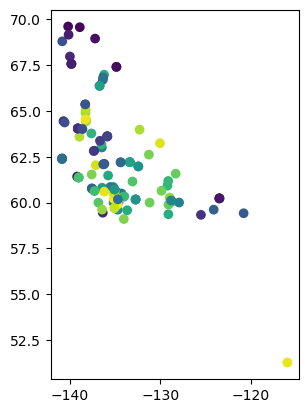

In [5]:
# load station metadata from RWIS DB

def get_stations(conn):
    """Get all stations from stations_stations table"""
    query = "SELECT * FROM stations_station;"
    with conn.cursor() as cur:
        cur.execute(query)
        columns = [desc[0] for desc in cur.description]  # Get column names
        rows = cur.fetchall()
        return rows, columns

# Connect to RWIS and get stations data
with rwis_connect() as conn:
    station_rows, station_columns = get_stations(conn)

# Convert to DataFrame
stations_df = pd.DataFrame(station_rows, columns=station_columns)

# Convert to GeoDataFrame
# Assuming 'longitude' and 'latitude' are the column names for coordinates
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
stations_gdf = gpd.GeoDataFrame(stations_df, geometry=geometry, crs="EPSG:4326")

# Display the first few rows of the GeoDataFrame
stations_gdf[stations_gdf.latitude != -999.0].plot(column='elevation', cmap='viridis')

As a sanity check, we compare the 1-hour and 24-hour precip at one station. Overall it looks OK, makes sense that the 24-hour rain would have a much lower instantanious value.

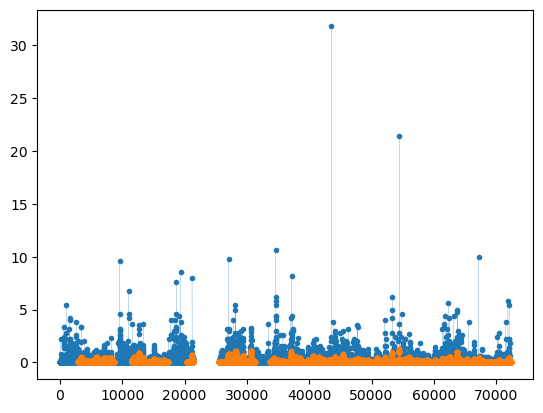

In [40]:
plt.plot(dfs_hourly[100]["pcp1"].values, '.-', linewidth=0.1)
plt.plot(dfs_hourly[100]["pcp24"].values, '.-', linewidth=0.1)

Here we plot precip. at all stations, we can see that some stations have some very high measurements, might be measuring snow on ground?

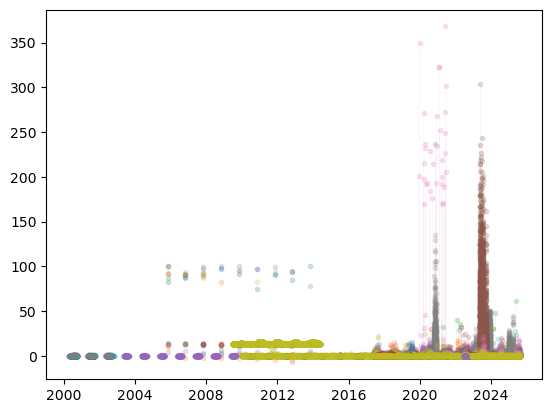

In [ ]:
for sid in station_ids:
    plt.plot(dfs_hourly[sid].index,dfs_hourly[sid]['pcp'].values, '.-', linewidth=0.1, alpha=0.2,label=sid)

Rename station IDs to abbrevs and export to csv

In [ ]:

rename_dict = stations_gdf.set_index('id')["abbreviation"].to_dict()

pcp.columns = [int(col) for col in pcp.columns]
pcp.columns = [rename_dict[col] if col in rename_dict.keys() else 'UNMATCHED_STN' for col in pcp.columns]
pcp.to_csv("precip.csv", index=True)


In [33]:
(~pcp.isna()).sum().sort_values(ascending=False)

CC       68583
VXY      66950
XQH      66561
SWI      65723
XCK      65220
         ...  
NKAK         0
SHAK4        0
CBAK         0
SHAK3        0
SHAK2        0
Length: 129, dtype: int64

Plotting two stations as a final sanity check.

(0.0, 12.0)

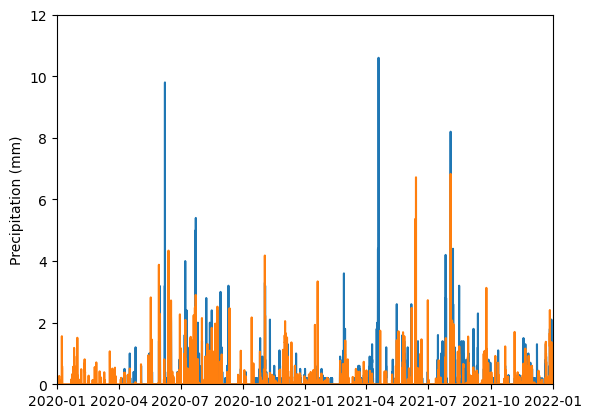

In [39]:
fig, ax = plt.subplots()
ax.plot(pcp["VXY"])
ax.plot(pcp["CC"])
ax.set_ylabel("Precipitation (mm)")

ax.set_xlim(datetime(2020, 1, 1), datetime(2022, 1, 1))
ax.set_ylim(0, 12)